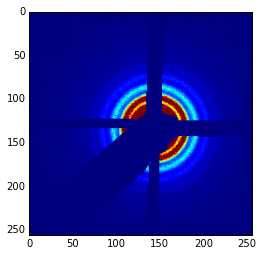

In [1]:
from skxray.core import roi 
import skxray.core.correlation as corr
from skxray.core import utils

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm

data_dir = "/Volumes/Data/BeamLines/CHX/Luxi_description_files_for_duke/"
duke_ndata = np.load(data_dir+"duke_img_1_5000.npy")
duke_dark = np.load(data_dir+"duke_dark.npy")

duke_data = []
for i in range(duke_ndata.shape[0]):
    duke_data.append(duke_ndata[i] - duke_dark)
    
duke_data = np.asarray(duke_data)    

avg_img = np.average(duke_data, axis=0)

mask4 = np.load(data_dir+"new_mask4.npy")

mask = np.load(data_dir+"Luxi_duke_mask.npy")

N_mask = ~(mask + mask4)

plt.imshow(N_mask*avg_img, vmax=1e0)
plt.show()

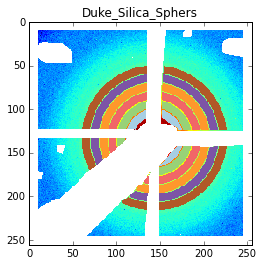

In [2]:
mask_data1 = N_mask*duke_data[0:2655]
mask_data2 = N_mask*duke_data[2659:4999]

inner_radius = 24
width = 9
spacing = 1
num_rings = 6

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)

rings = roi.rings(edges, (133, 143), avg_img.shape)

rings_mask = rings*N_mask

# extarct the ROI's lables and pixel indices corresponding to those labels
q_inds, pixel_list = roi.extract_label_indices(rings*N_mask)

def test_demo(ax, inds, pix_list, img_dim, image):
    """
    This will plot the reqiured roi's on the image
    """
    tt = np.zeros(img_dim).ravel() * np.nan
    tt[pix_list] = inds

    im = ax.imshow(image, interpolation='none', norm=LogNorm())
    im = ax.imshow(tt.reshape(*img_dim), cmap='Paired', interpolation='nearest')
    
fig, ax = plt.subplots()
plt.title("Duke_Silica_Sphers")
test_demo(ax, q_inds, pixel_list, avg_img.shape, avg_img*N_mask)
plt.show()

In [3]:
images = N_mask*duke_data
images.shape

(5000, 256, 256)

In [4]:
from __future__ import absolute_import, division, print_function
import logging
import time

import numpy as np

#from . import roi
#from . import utils

logger = logging.getLogger(__name__)


def multi_tau_auto_corr(num_levels, num_bufs, labels, images):
    """
    This function computes one-time correlations.
    multi_tau_auto_corr Original code(in Yorick): @author: Mark Sutton

    It uses a scheme to achieve long-time correlations inexpensively
    by downsampling the data, iteratively combining successive frames.

    The longest lag time computed is num_levels * num_bufs.

    Parameters
    ----------
    num_levels : int
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames

    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling

    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    images : array
        dimensions are: (rr, cc), iterable of 2D arrays

    Returns
    -------
    g2 : array
        matrix of normalized intensity-intensity autocorrelation
        shape (num_levels, number of labels(ROI))

    lag_steps : array
        delay or lag steps for the multiple tau analysis
        shape num_levels

    Notes
    -----

    The normalized intensity-intensity time-autocorrelation function
    is defined as

    :math ::
        g_2(q, t') = \frac{<I(q, t)I(q, t + t')> }{<I(q, t)>^2}

    ; t' > 0

    Here, I(q, t) refers to the scattering strength at the momentum
    transfer vector q in reciprocal space at time t, and the brackets
    <...> refer to averages over time t. The quantity t' denotes the
    delay time

    This implementation is based on code in the language Yorick
    by Mark Sutton, based on published work. [1]_

    References
    ----------

    .. [1] D. Lumma, L. B. Lurio, S. G. J. Mochrie and M. Sutton,
        "Area detector based photon correlation in the regime of
        short data batches: Data reduction for dynamic x-ray
        scattering," Rev. Sci. Instrum., vol 70, p 3274-3289, 2000.

    """
    # In order to calculate correlations for `num_bufs`, images must be
    # kept for up to the maximum lag step. These are stored in the array
    # buffer. This algorithm only keeps number of buffers and delays but
    # several levels of delays number of levels are kept in buf. Each
    # level has twice the delay times of the next lower one. To save
    # needless copying, of cyclic storage of images in buf is used.

    label_mask, pixel_list, num_rois, num_pixels = _validate_inputs(num_bufs, labels, images)
    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, np.sum(num_pixels)),
                   dtype=np.float64)

    # to track processing each level
    track_level = np.zeros(num_levels)

    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)

    # G holds the un normalized auto-correlation result. We
    # accumulate computations into G as the algorithm proceeds.
    G = np.zeros(((num_levels + 1)*num_bufs/2, num_rois),
                 dtype=np.float64)

    # matrix of past intensity normalizations
    past_intensity_norm = np.zeros(((num_levels + 1)*num_bufs/2, num_rois),
                                   dtype=np.float64)

    # matrix of future intensity normalizations
    future_intensity_norm = np.zeros(((num_levels + 1)*num_bufs/2, num_rois),
                                     dtype=np.float64)

    start_time = time.time()  # used to log the computation time (optionally)

    for n, img in enumerate(images):

        cur[0] = (1 + cur[0]) % num_bufs  # increment buffer

        # Put the image into the ring buffer.
        buf[0, cur[0] - 1] = (np.ravel(img))[pixel_list]

        # Compute the correlations between the first level
        # (undownsampled) frames. This modifies G,
        # past_intensity_norm, future_intensity_norm,
        # and img_per_level in place!
        _process(buf, G, past_intensity_norm,
                 future_intensity_norm, label_mask,
                 num_bufs, num_pixels, img_per_level,
                 level=0, buf_no=cur[0] - 1)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        # (Compute the correlations for all higher levels)
        level = 1

        while level < num_levels:
            if not track_level[level]:
                track_level[level] = 1
            else:
                prev = 1 + (cur[level - 1] - 2) % num_bufs
                cur[level] = 1 + cur[level] % num_bufs

                buf[level, cur[level] - 1] = (buf[level - 1, prev - 1] +
                                              buf[level - 1,
                                                  cur[level - 1] - 1])/2

                # make the track_level zero once that level is processed
                track_level[level] = 0

                # call the _process function for each multi-tau level
                # for multi-tau levels greater than one
                # Again, this is modifying things in place. See comment
                # on previous call above.
                _process(buf, G, past_intensity_norm,
                         future_intensity_norm, label_mask,
                         num_bufs, num_pixels, img_per_level,
                         level=level, buf_no=cur[level]-1,)
                level += 1

    # ending time for the process
    end_time = time.time()

    logger.info("One Time Correlation - Processing time for {0} images took"
                " {1} seconds." .format(n, (end_time - start_time)))

    # the normalization factor
    if len(np.where(past_intensity_norm == 0)[0]) != 0:
        g_max = np.where(past_intensity_norm == 0)[0][0]
    else:
        g_max = past_intensity_norm.shape[0]

    # g2 is normalized G
    g2 = (G[:g_max] / (past_intensity_norm[:g_max] *
                       future_intensity_norm[:g_max]))

    # Convert from num_levels, num_bufs to lag frames.
    tot_channels, lag_steps = utils.multi_tau_lags(num_levels, num_bufs)
    lag_steps = lag_steps[:g_max]

    return g2, lag_steps


def _process(buf, G, past_intensity_norm, future_intensity_norm,
             label_mask, num_bufs, num_pixels, img_per_level, level, buf_no):
    """
    Internal helper function. This modifies inputs in place.

    This helper function calculates G, past_intensity_norm and
    future_intensity_norm at each level, symmetric normalization is used.

    Parameters
    ----------
    buf : array
        image data array to use for correlation

    G : array
        matrix of auto-correlation function without
        normalizations

    past_intensity_norm : array
        matrix of past intensity normalizations

    future_intensity_norm : array
        matrix of future intensity normalizations

    label_mask : array
        labels of the required region of interests(roi's)

    num_bufs : int, even
        number of buffers(channels)

    num_pixels : array
        number of pixels in certain roi's
        roi's, dimensions are : [number of roi's]X1

    img_per_level : array
        to track how many images processed in each level

    level : int
        the current multi-tau level

    buf_no : int
        the current buffer number

    Notes
    -----
    :math ::
        G   = <I(\tau)I(\tau + delay)>

    :math ::
        past_intensity_norm = <I(\tau)>

    :math ::
        future_intensity_norm = <I(\tau + delay)>

    """
    img_per_level[level] += 1

    # in multi-tau correlation other than first level all other levels
    #  have to do the half of the correlation
    if level == 0:
        i_min = 0
    else:
        i_min = num_bufs//2

    for i in range(i_min, min(img_per_level[level], num_bufs)):

        (t_index, tmp_binned, pi_binned,
         fi_binned) = _help_process(level, num_bufs, buf_no, i, buf,
                                    label_mask)

        #  get the matrix of auto-correlation function without normalizations
        G[t_index] += ((tmp_binned / num_pixels - G[t_index]) /
                       (img_per_level[level] - i))

        # get the matrix of past intensity normalizations
        past_intensity_norm[t_index] += ((pi_binned/num_pixels
                                         - past_intensity_norm[t_index]) /
                                         (img_per_level[level] - i))

        # get the matrix of future intensity normalizations
        future_intensity_norm[t_index] += ((fi_binned/num_pixels
                                           - future_intensity_norm[t_index]) /
                                           (img_per_level[level] - i))

    return None  # modifies arguments in place!


def auto_corr_scat_factor(lags, beta, relaxation_rate, baseline=1):
    """
    This model will provide normalized intensity-intensity time
    correlation data to be minimized.

    Parameters
    ----------
    lags : array
        delay time

    beta : float
        optical contrast (speckle contrast), a sample-independent
        beamline parameter

    relaxation_rate : float
        relaxation time associated with the samples dynamics.

    baseline : float, optional
        baseline of one time correlation
        equal to one for ergodic samples

    Returns
    -------
    g2 : array
        normalized intensity-intensity time autocorreltion

    :math ::
        g_1(q, \tau) = e^{-\gamma(q) \tau}

    :math ::
       g_2(q, \tau) = \beta_1 e^{-2\gamma(q) \tau} + g_\infty

    These implementation are based on published work. [1]_

    References
    ----------
    .. [1] L. Li, P. Kwasniewski, D. Orsi, L. Wiegart, L. Cristofolini,
       C. Caronna and A. Fluerasu, " Photon statistics and speckle
       visibility spectroscopy with partially coherent X-rays,"
       J. Synchrotron Rad. vol 21, p 1288-1295, 2014

    """
    return beta*np.exp(-2*relaxation_rate*lags) + baseline


def two_time(num_levels, num_bufs, labels, images):
    """
    This function computes two-time correlations.
    two_time_corr Original code : @author: Yugang Zhang

    It uses a scheme to achieve long-time correlations inexpensively
    by downsampling the data, iteratively combining successive frames.

    The longest lag time computed is num_levels * num_bufs.
    ** see comments on multi_tau_auto_corr

    Parameters
    ----------
    num_levels : int
        how many generations of downsampling to perform, i.e.,
        the depth of the binomial tree of averaged frames

    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling

    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    images : array
        dimensions are: (rr, cc), iterable of 2D arrays

    Returns
    -------
    two_time_c : array
        matrix of two_time correlation
        shape (number of images, number of images, number of labels(ROI))

    Notes
    -----
    The two-time correlation function is defined as

    :math ::
        C(q, t_1, t_2) = \frac{<I(q, t_1)I(q, t_2)>_pix }{<I(q, t_1)>_pix <I(q, t_2)>_pix}

    Here, the ensemble averages are performed over many pixels of detector,
    all having the same q value. The average time or age is equal to (t1+t2)/2,
    measured by the distance along the t1 = t2 diagonal.
    The time difference t = |t1 - t2|, with is distance from the t1 = t2
    diagonal in the perpendicular direction.
    In the equilibrium system, the two-time correlation functions depend only
    on the time difference t, and hence the two-time correlation contour lines
    are parallel.

    References
    ----------

    .. [1] A. Fluerasu, A. Moussaid, A. Mandsen and A. Schofield,
        "Slow dynamics and aging in collodial gels studied by x-ray photon
         correlation spectroscopy," Phys. Rev. E., vol 76, p 010401(1-4), 2007.
    """

    label_mask, pixel_list, num_rois, num_pixels = _validate_inputs(num_bufs,
                                                                    labels,
                                                                    images)

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, np.sum(num_pixels)),
                   dtype=np.float64)

    # to track processing each level
    track_level = np.zeros(num_levels)

    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)

    # two time correlation results
    two_time_c = np.zeros((images[0].shape[0],
                           images[0].shape[0], num_rois),
                          dtype=np.float64)

    # to count images in each level
    count_level = np.zeros(num_levels, dtype=np.int64)

    # generate a time frame for each level
    time_ind = {key: [] for key in range(num_levels)}

    start_time = time.time()  # used to log the computation time (optionally)
    #  for two time correlation

    tot_channels, lag_steps = utils.multi_tau_lags(num_levels, num_bufs)

    for n, img in enumerate(images):
        cur[0] = (1 + cur[0]) % num_bufs  # increment buffer

        count_level[0] = 1 + count_level[0]
        # current image number
        current_img_time = n + 1

        # Put the image into the ring buffer.
        buf[0, cur[0] - 1] = (np.ravel(img))[pixel_list]

        # Compute the two time correlations between the first level
        # (undownsampled) frames. two_time_c and img_per_level in place!
        _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                          img_per_level, lag_steps, current_img_time, level=0,
                          buf_no=cur[0] - 1)

        # time frame for each level
        time_ind[0].append(current_img_time)

        # check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        # Compute the correlations for all higher levels.
        level = 1
        while processing:
            if not track_level[level]:
                track_level[level] = 1
                processing = False
            else:
                prev = 1 + (cur[level - 1] - 2) % num_bufs
                cur[level] = 1 + cur[level] % num_bufs
                count_level[level] = 1 + count_level[level]

                buf[level, cur[level] - 1] = (buf[level - 1, prev - 1] +
                                              buf[level - 1,
                                                  cur[level - 1] - 1])/2

                t1_idx = (count_level[level] - 1) * 2

                current_img_time = ((time_ind[level - 1])[t1_idx]
                                    + (time_ind[level - 1])[t1_idx + 1])/2.

                # time frame for each level
                time_ind[level].append(current_img_time)

                # make the track_level zero once that level is processed
                track_level[level] = 0

                # call the _two_time_process function for each multi-tau level
                # for multi-tau levels greater than one
                # Again, this is modifying things in place. See comment
                # on previous call above.
                _two_time_process(buf, two_time_c, label_mask, num_bufs,
                                  num_pixels, img_per_level, lag_steps,
                                  current_img_time, level=level,
                                  buf_no=cur[level]-1)
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels

    for q in range(np.max(labels)):
        x0 = two_time_c[:, :, q]
        two_time_c[:, :, q] = (np.tril(x0) + np.tril(x0).T
                               - np.diag(np.diag(x0)))
    # Two time correlation processing time
    logger.info("Two Time Correlation - Processing time for {0} images took"
                " {1} seconds." .format(n, (time.time() - start_time)))

    return two_time_c


def _two_time_process(buf, two_time_c, label_mask, num_bufs, num_pixels,
                      img_per_level, lag_steps, current_img_time, level,
                      buf_no):
    """
    Parameters
    ----------
    buf: array
        image data array to use for two time correlation

    two_time_c: array
        two time correlation matrix

    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments

    num_bufs: int, even
        number of buffers(channels)

    num_pixels : array
        number of pixels in certain roi's
        roi's, dimensions are : [number of roi's]

    img_per_level: array
        to track how many images processed in each level

    lag_steps : array
        delay or lag steps for the multiple tau analysis
        shape num_levels

    current_img_time : int
        the current image number

    level : int
        the current multi-tau level

    buf_no : int
        the current buffer number

    """
    img_per_level[level] += 1

    # in multi-tau correlation other than first level all other levels
    #  have to do the half of the correlation
    if level == 0:
        i_min = 0
    else:
        i_min = num_bufs//2

    for i in range(i_min, min(img_per_level[level], num_bufs)):
        (t_index, tmp_binned, pi_binned,
         fi_binned) = _help_process(level, num_bufs, buf_no, i, buf,
                                    label_mask)

        tind1 = (current_img_time - 1)

        tind2 = (current_img_time - lag_steps[t_index] - 1)

        if not isinstance(current_img_time, int):
            nshift = 2**(level-1)
            for i in range(-nshift+1, nshift+1):
                two_time_c[int(tind1+i),
                           int(tind2+i)] = (tmp_binned/(pi_binned *
                                                        fi_binned))*num_pixels
        else:
            two_time_c[tind1, tind2] = tmp_binned/(pi_binned *
                                                   fi_binned)*num_pixels


def _help_process(level, num_bufs, buf_no, i, buf, label_mask):
    """
    This is a helper function for both one time and two time correlation
    process functions.

    Parameters
    ----------
    level : int
        the current multi-tau level

    num_bufs : int
        number of buffers(channels)

    buf_no : int
        the current buffer number

    i : int

    buf : array
        image data array to use for two time correlation

    label_mask: array
        Elements not inside any ROI are zero; elements inside each
        ROI are 1, 2, 3, etc. corresponding to the order they are specified
        in edges and segments

    Returns
    -------
    t_index : float
        time

    tmp_binned : array
        matrix of correlation function without normalizations

    pi_binned : array
        matrix of past intensity normalizations

    fi_binned : array
        matrix of future intensity normalizations
    """
    t_index = level*num_bufs/2 + i

    delay_no = (buf_no - i) % num_bufs

    past_img = buf[level, delay_no]
    future_img = buf[level, buf_no]

    #  get the matrix of correlation function without normalizations
    tmp_binned = (np.bincount(label_mask,
                              weights=past_img*future_img)[1:])
    # get the matrix of past intensity normalizations
    pi_binned = (np.bincount(label_mask,
                             weights=past_img)[1:])

    # get the matrix of future intensity normalizations
    fi_binned = (np.bincount(label_mask,
                             weights=future_img)[1:])
    return t_index, tmp_binned, pi_binned, fi_binned


def _validate_inputs(num_bufs, labels, images):
    """
    This is a helper function to validate inputs for both one time and
    two time correlation

    Parameters
    ----------
    num_bufs : int, must be even
        maximum lag step to compute in each generation of
        downsampling

    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    images : iterable of 2D arrays
        dimensions are: (rr, cc)

    Returns
    -------
    label_mask : array
        labels of the required region of interests(ROI's)

    indices : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]

    num_rois : array
        number of ROI's

    num_pixels : array
        number of pixels in each ROI's
    """
    if num_bufs % 2 != 0:
        raise ValueError("number of channels(number of buffers) in "
                         "multiple-taus (must be even)")

    #if labels.shape != images.operands[0].shape[1:]:
    #    raise ValueError("Shape of the image stack should be equal to"
    #                     " shape of the labels array")

    if hasattr(images, 'frame_shape'):
        # Give a user-friendly error if we can detect the shape from pims.
        if labels.shape != images.frame_shape:
            raise ValueError("Shape of the images should be equal to"
                             " shape of the labels array")

    # get the pixels in each label
    label_mask, indices = roi.extract_label_indices(labels)

    num_rois = np.max(label_mask)

    # number of pixels per ROI
    num_pixels = np.bincount(label_mask, minlength=(num_rois+1))
    num_pixels = num_pixels[1:]

    if np.any(num_pixels == 0):
        raise ValueError("Number of pixels of the required roi's"
                         " cannot be zero, "
                         "num_pixels = {0}".format(num_pixels))


In [12]:
g2, lag_steps = corr.multi_tau_auto_corr(2, 4, rings_mask,
                                             images)

In [5]:
two_time_s = two_time(3, 4, rings_mask, images)

TypeError: 'NoneType' object is not iterable

In [6]:
from skimage import data
from skimage.viewer import ImageViewer
from skimage.viewer.plugins.lineprofile import LineProfile


/Users/sameera/mc/envs/work/lib/python2.7/site-packages/skimage/viewer/utils/core.py:11: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warnings.warn("Recommended matplotlib backend is `Agg` for full "
